In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('accepts.csv')
df.info(); df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8210 entries, 0 to 8209
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   application_id  8210 non-null   int64  
 1   account_number  8210 non-null   int64  
 2   bad_ind         8210 non-null   float64
 3   vehicle_year    8210 non-null   int64  
 4   vehicle_make    8210 non-null   object 
 5   bankruptcy_ind  8210 non-null   float64
 6   tot_derog       8210 non-null   int64  
 7   tot_tr          8210 non-null   int64  
 8   age_oldest_tr   8210 non-null   float64
 9   tot_open_tr     8210 non-null   int64  
 10  tot_rev_tr      8210 non-null   int64  
 11  tot_rev_debt    8210 non-null   int64  
 12  tot_rev_line    8210 non-null   int64  
 13  rev_util        8210 non-null   int64  
 14  fico_score      8210 non-null   int64  
 15  purch_price     8210 non-null   float64
 16  msrp            8210 non-null   float64
 17  down_pyt        8210 non-null   f

application_id  account_number  bad_ind  vehicle_year vehicle_make  \
1943         6270671         4684764      0.0          1995       TOYOTA   
5673         7360456         3857869      1.0          1996    CHEVROLET   
4924         2902802         2038489      0.0          1999         FORD   
5773         6221616         4055112      0.0          2000         AUDI   
3554         8372870         8641755      0.0          1999           VW   

      bankruptcy_ind  tot_derog  tot_tr  age_oldest_tr  tot_open_tr  ...  \
1943             0.0          0      43          385.0           10  ...   
5673             0.0          0      10          268.0            5  ...   
4924             0.0         16      30          194.0            4  ...   
5773             0.0          0      38          330.0           10  ...   
3554             0.0          0      20           97.0           10  ...   

      purch_price     msrp  down_pyt  loan_term  loan_amt  ltv  tot_income  \
1943      13400.0  13000.0     900.0         54   12500.0  105     5791.67   
5673      19400.0  16025.0       0.0         60   19400.0  132        0.00   
4924      28265.0  30680.0       0.0         66   28265.0   92     2117.00   
5773      36000.0  35625.0       0.0         36   36000.0  101     8333.33   
3554      15995.0  15995.0       0.0         30   15995.0  103     3025.00   

      veh_mileage  used_ind  weight  
1943        63000         1    4.75  
5673        40000         1    1.00  
4924            1         1    4.75  
5773            1         0    4.75  
3554         8900         1    4.75  

[5 rows x 25 columns]

In [2]:
df['bad_ind'].value_counts()

0.0    6638
1.0    1572
Name: bad_ind, dtype: int64

# 拆分测试集和训练集

In [3]:
df.columns

Index(['application_id', 'account_number', 'bad_ind', 'vehicle_year',
       'vehicle_make', 'bankruptcy_ind', 'tot_derog', 'tot_tr',
       'age_oldest_tr', 'tot_open_tr', 'tot_rev_tr', 'tot_rev_debt',
       'tot_rev_line', 'rev_util', 'fico_score', 'purch_price', 'msrp',
       'down_pyt', 'loan_term', 'loan_amt', 'ltv', 'tot_income', 'veh_mileage',
       'used_ind', 'weight'],
      dtype='object')

In [4]:
target = df['bad_ind']
data = df.loc[:, 'bankruptcy_ind': 'used_ind']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, 
                                                    random_state=42)

# 决策树建模

## 初始化决策树

In [5]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=1234) 

## 训练决策树

In [6]:
clf.fit(X=X_train, y=y_train)
print(f'决策树的深度：{clf.tree_.max_depth}, 叶子节点数：{clf.tree_.n_leaves}')

决策树的深度：3, 叶子节点数：8


## 模型表现

In [7]:
# metrics 输出分类报告
import sklearn.metrics as metrics
print(metrics.classification_report(y_true=y_test, y_pred=clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      2161
         1.0       0.88      0.01      0.03       549

    accuracy                           0.80      2710
   macro avg       0.84      0.51      0.46      2710
weighted avg       0.81      0.80      0.71      2710



模型的平均 recall 似乎还不错，有0.8，但对于因变量为1（违约）的数据，召回率recall仅为0.01。

也就是说，在所有违约的用户中，模型技能识别出其中的 1%，这说明模型识别违约用户的能力严重不足。

又因为1个违约用户带来的损失远远超过1个履约用户带来的收益，所以模型优化势在必行。

In [8]:
# 权重法优化
clf = DecisionTreeClassifier(class_weight={0:1, 1:3}, criterion='gini', max_depth=3, random_state=1234) 
clf.fit(X=X_train, y=y_train)
print(metrics.classification_report(y_true=y_test, y_pred=clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.91      0.60      0.73      2161
         1.0       0.33      0.77      0.46       549

    accuracy                           0.64      2710
   macro avg       0.62      0.69      0.59      2710
weighted avg       0.79      0.64      0.67      2710



In [9]:
list(zip(X_train.columns, clf.feature_importances_))

[('bankruptcy_ind', 0.0),
 ('tot_derog', 0.0),
 ('tot_tr', 0.0),
 ('age_oldest_tr', 0.0),
 ('tot_open_tr', 0.0),
 ('tot_rev_tr', 0.0),
 ('tot_rev_debt', 0.0),
 ('tot_rev_line', 0.1294798573577349),
 ('rev_util', 0.0),
 ('fico_score', 0.6366583402248946),
 ('purch_price', 0.0),
 ('msrp', 0.0),
 ('down_pyt', 0.0),
 ('loan_term', 0.0),
 ('loan_amt', 0.0),
 ('ltv', 0.23386180241737037),
 ('tot_income', 0.0),
 ('veh_mileage', 0.0),
 ('used_ind', 0.0)]

## 决策树可视化

In [10]:
plt.rc('font', **{'family': 'Microsoft YaHei, SimHei'})  # 设置中文字体的支持

[Text(0.5, 0.875, 'fico_score <= 699.5\ngini = 0.483\nsamples = 5500\nvalue = [4477, 3069]\nclass = 0-履约'),
 Text(0.25, 0.625, 'tot_rev_line <= 13781.5\ngini = 0.497\nsamples = 2839\nvalue = [2038, 2403]\nclass = 1-违约'),
 Text(0.125, 0.375, 'ltv <= 113.5\ngini = 0.479\nsamples = 1931\nvalue = [1281, 1950]\nclass = 1-违约'),
 Text(0.0625, 0.125, 'gini = 0.492\nsamples = 1597\nvalue = [1116, 1443]\nclass = 1-违约'),
 Text(0.1875, 0.125, 'gini = 0.37\nsamples = 334\nvalue = [165, 507]\nclass = 1-违约'),
 Text(0.375, 0.375, 'fico_score <= 655.5\ngini = 0.468\nsamples = 908\nvalue = [757, 453]\nclass = 0-履约'),
 Text(0.3125, 0.125, 'gini = 0.5\nsamples = 325\nvalue = [241, 252]\nclass = 1-违约'),
 Text(0.4375, 0.125, 'gini = 0.403\nsamples = 583\nvalue = [516, 201]\nclass = 0-履约'),
 Text(0.75, 0.625, 'ltv <= 110.5\ngini = 0.337\nsamples = 2661\nvalue = [2439, 666]\nclass = 0-履约'),
 Text(0.625, 0.375, 'ltv <= 95.5\ngini = 0.232\nsamples = 2004\nvalue = [1906, 294]\nclass = 0-履约'),
 Text(0.5625, 0.125

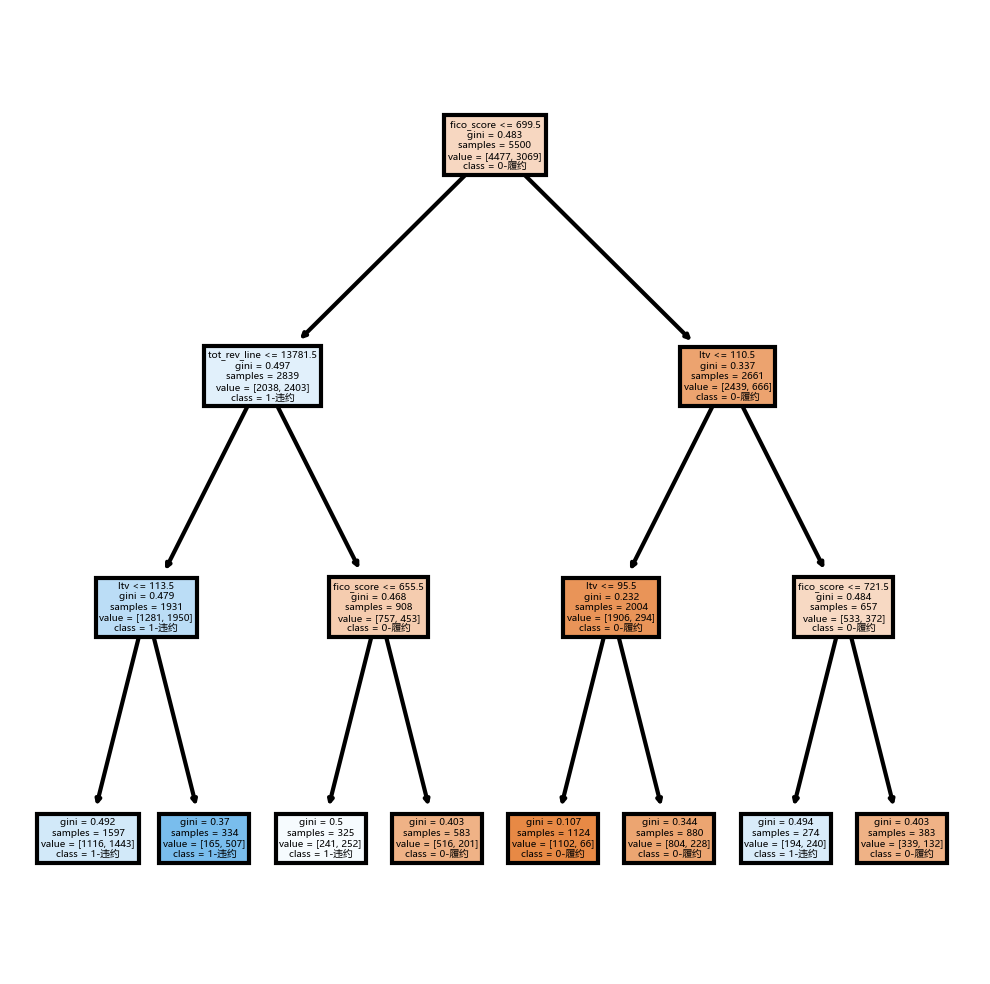

In [11]:
import sklearn.tree as tree
fn = data.columns.tolist()  # 条件名
cn = ['0-履约', '1-违约'] # 行为标签名

fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (4,4), dpi=300)
tree.plot_tree(decision_tree = clf,
               feature_names = fn, 
               class_names = cn,
               filled = True)

In [12]:
from dtreeplot import model_plot

In [13]:
model_plot(model=clf, features=X_test.columns.tolist(), labels=y_test, width=1000, height=500)

# 网格搜索法实现模型优化

In [14]:
from sklearn.model_selection import GridSearchCV
# 下面的各个参数的潜在数值也只是一种尝试，具体还得结合实际业务场景
param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [None, ],
    'max_leaf_nodes':[5,6,7,8,9,10],
    'class_weight': [ {0:1, 1:2}, {0:1, 1:3} ]
}

# 在定义树的时候先不着急放参数
clf = DecisionTreeClassifier() 
clfcv = GridSearchCV(estimator=clf, param_grid=param_grid, 
                   scoring='roc_auc', cv=5) # scoring：评分依据，cv：交叉验证

clfcv.fit(X_train, y_train) # 需要一定时间

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}],
                         'criterion': ['entropy', 'gini'], 'max_depth': [None],
                         'max_leaf_nodes': [5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')

In [15]:
"""
网格搜索训练决策树模型的输出信息如下:
GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}],
                         'criterion': ['entropy', 'gini'], 'max_depth': [None],
                         'max_leaf_nodes': [5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')
"""

"\n网格搜索训练决策树模型的输出信息如下:\nGridSearchCV(cv=5, estimator=DecisionTreeClassifier(),\n             param_grid={'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}],\n                         'criterion': ['entropy', 'gini'], 'max_depth': [None],\n                         'max_leaf_nodes': [5, 6, 7, 8, 9, 10]},\n             scoring='roc_auc')\n"

In [16]:
print(metrics.classification_report(y_true=y_test, y_pred=clfcv.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.88      0.74      0.81      2161
         1.0       0.38      0.61      0.47       549

    accuracy                           0.72      2710
   macro avg       0.63      0.68      0.64      2710
weighted avg       0.78      0.72      0.74      2710



In [17]:
clfcv.best_params_

{'class_weight': {0: 1, 1: 3},
 'criterion': 'gini',
 'max_depth': None,
 'max_leaf_nodes': 10}

# 优化决策边界

In [18]:
param_grid = {
    'criterion': ['gini'],
    'max_depth': [None, ],
    'max_leaf_nodes':[10,11,12,13,14,15],  # 直接从 10 开始
    'class_weight': [ {0:1,1:3}, {0:1,1:4}, {0:1,1:5} ]
}
clf = DecisionTreeClassifier() 
clfcv = GridSearchCV(estimator=clf, param_grid=param_grid, 
                   scoring='roc_auc', cv=5) 
clfcv.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 3}, {0: 1, 1: 4},
                                          {0: 1, 1: 5}],
                         'criterion': ['gini'], 'max_depth': [None],
                         'max_leaf_nodes': [10, 11, 12, 13, 14, 15]},
             scoring='roc_auc')

In [19]:
print(metrics.classification_report(y_true=y_test, y_pred=clfcv.predict(X_test)))
clfcv.best_params_

              precision    recall  f1-score   support

         0.0       0.91      0.63      0.74      2161
         1.0       0.34      0.75      0.47       549

    accuracy                           0.65      2710
   macro avg       0.62      0.69      0.60      2710
weighted avg       0.79      0.65      0.69      2710



{'class_weight': {0: 1, 1: 4},
 'criterion': 'gini',
 'max_depth': None,
 'max_leaf_nodes': 15}

# ROC ＆ AUC

C:\Users\Rocloo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Rocloo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


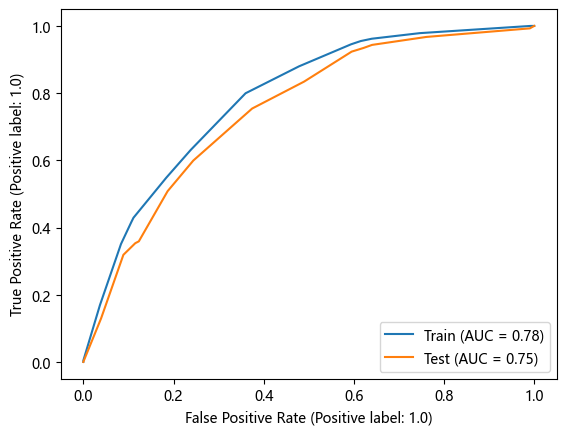

In [20]:
from sklearn.metrics import plot_roc_curve
# 通常会将训练集和测试集的曲线绘制在一起，以便查看是否存在过拟合的情况
fig, ax = plt.subplots()
plot_roc_curve(estimator=clfcv, X=X_train, y=y_train, ax=ax, name='Train')
plot_roc_curve(estimator=clfcv, X=X_test, y=y_test, ax=ax, name='Test')